<a href="https://colab.research.google.com/github/adeepH/DravidianOffensive/blob/main/Notebooks/CM-TRA/Malayalam/muril.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers 

In [2]:
import re
import time
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW
from sklearn.metrics import classification_report
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
% matplotlib inline

In [3]:
!git clone https://github.com/adeepH/DravidianOffensive.git

fatal: destination path 'DravidianOffensive' already exists and is not an empty directory.


In [4]:
path = []
root_path = '/content/DravidianOffensive/Datasets/'
train_ = root_path + 'kannada_offensive_train (1).csv'
test_ = root_path + 'kannada_offensive_test_with_labels.csv'
val_ = root_path + 'kannada_offensive_dev.csv'
path.append(train_)
path.append(val_)
path.append(test_)
def load_files(path):
    p = []
    for i in range(0,len(path)):
        p.append(pd.read_csv(path[i],header=None,names=['tweets','label'],sep="\t"))
        p[i]['labels'] = LabelEncoder().fit_transform(p[i]['label'])
        p[i] = p[i].drop(columns='label')
    return p[0],p[1],p[2]
from sklearn.preprocessing import LabelEncoder
train, val, test = load_files(path)

In [5]:
train=pd.read_csv('/content/DravidianOffensive/Datasets/Pseudo Labels/Pseudo_Mal.csv')
train['labels']=LabelEncoder().fit_transform(train['labels']) 
#for i in range(len(train)):
#  train['tweets'][i]=train['tweets'][i][8:-2]
train=train.drop(columns=['Unnamed: 0'])
train

,tweets,labels
0,പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ് അല്ലാതെ സ്വന്ത...,0
1,ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവ...,0
2,ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്...,0
3,Sushin syam Shaiju khalid Midhun manual,0
4,J A K E S. B EJ O Y !!!,0
...,...,...
38014,{'ml': 'അരുടേയും കാണീർ ഓപ്പൺ വന്നദല്ല ഞൈൻ... !...,0
38015,{'ml': 'മലയാളം ലേഡി സൂപ്പർ സ്റ്റാർ......അതുക് ...,0
38016,{'ml': 'ഇൻഡ്യൻ സിനിമ ലിവിംഗ് ലെഗഡ് മോളിവുഡ് കി...,0
38017,{'ml': 'ചെറിയ തെറ്റുകൾ എടുത്തു കളയണം. പിന്നീട്...,0


In [6]:
train.labels.value_counts()

0    35926
4     1466
2      263
3      211
1      153
Name: labels, dtype: int64

In [7]:
val=pd.read_csv('/content/DravidianOffensive/Datasets/Trans_mal_test.csv')
val['labels']=LabelEncoder().fit_transform(val['label'])
val['tweets']=val['Sentence']
#for i in range(len(val)):
#  val['tweets'][i]=val['tweets'][i][8:-2]
val=val.drop(columns=['label','Unnamed: 0','transliterated','Sentence'])
val

,labels,tweets
0,0,അപ്പൊ ഇതൊരൊന്നൊരാ മൊതലാണല്ലേ Suraj ആണ് നടൻ ന്...
1,0,എന്ത് ഊള എഡിറ്റിംഗ് ആടോ ഇത് ഒരുമാതിരി vivo vid...
2,0,Fefka ee padam release cheyyan samadhicho?
3,0,അആഹാ.. സംഗീതം ജെക്‌സ് ബിജോയ് ആണ് അപ്പൊ പൊട്ടലു...
4,0,Ravile thane views likes ethra ayyi enn nokan ...
...,...,...
1996,0,Swargatthil ninnu purathaakkappetta daivatthin...
1997,0,Ivide Palakkad Jayettan Fans club nnu ashamsak...
1998,0,ഈ പടത്തിന് വെയിറ്റ് ചെയ്യുന്ന മമ്മൂക്ക ഫാൻസും
1999,0,കട്ട ലാലേട്ടൻ ഫാൻസ് ഒരു ലൈക് തന്നിട്ട് പോവാമോ ...


In [8]:
val.labels.value_counts()

0    1765
4     157
3      29
2      27
1      23
Name: labels, dtype: int64

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [10]:
train_sentences = train['tweets'].values.tolist()
val_sentences = val['tweets'].values.tolist()
#test_sentences = test['tweets'].values.tolist()

In [11]:
def preprocess_texts(sentences):
  sentences = [re.sub(r'http\S+','',s) for s in sentences]
  sentences = [s.replace('#','') for s in sentences]
  sentences = [s + " [SEP] [CLS]" for s in sentences]
  return sentences

In [12]:
train_sentences = preprocess_texts(train_sentences)
val_sentences = preprocess_texts(val_sentences)
#test_sentences = preprocess_texts(test_sentences)

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained('google/muril-base-cased', do_lower_case=True)

tokenized_texts_train = [tokenizer.tokenize(s) for s in train_sentences]
tokenized_texts_val = [tokenizer.tokenize(s) for s in val_sentences]
#tokenized_texts_test = [tokenizer.tokenize(s) for s in test_sentences]
print (tokenized_texts_train[0])

['പല', '##ദേശം', '.', 'പല', 'ഭാഷ', 'ഒരേ', 'ഒരു', 'രാജാവ്', 'അല്ലാതെ', 'സ്വന്തം', 'രാജ', '##വ', '##യത്', 'അല്ല', '[SEP]', '[CLS]']


In [14]:
train['len'] = [len(s.split()) for s in train['tweets']]
val['len'] = [len(s.split()) for s in val['tweets']]
#test['len'] = [len(s.split()) for s in test['tweets']]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


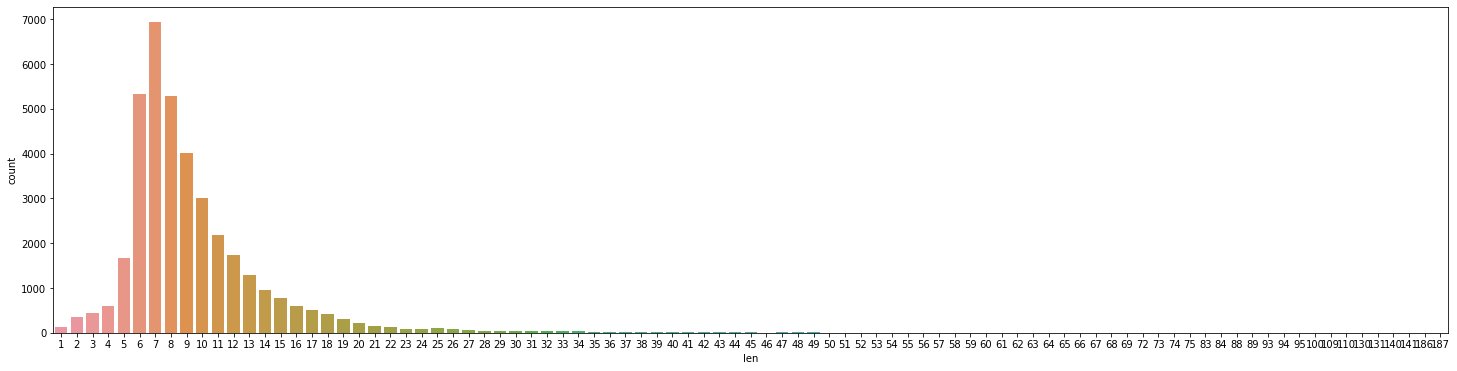

In [15]:
plt.figure(figsize=(25,6))
sns.countplot(train['len'])

In [16]:
MAX_LEN = 128
input_ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids_val = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_val]
#input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]

input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
#input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long", truncating="post",padding="post")

In [17]:

attention_masks_train = []
attention_masks_val = []
attention_masks_test = []
for seq in input_ids_train:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_train.append(seq_mask)

for seq in input_ids_val:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_val.append(seq_mask)

#for seq in input_ids_test:
#    seq_mask =[float(i>0) for i in seq]
#    attention_masks_test.append(seq_mask)

In [18]:
train_labels, validation_labels = train['labels'].values.tolist(), val['labels'].values.tolist()#, test['labels'].values.tolist()

In [19]:
train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_val)
#test_inputs = torch.tensor(input_ids_test)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
#test_labels = torch.tensor(test_labels)
train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_val)
#test_masks = torch.tensor(attention_masks_test)

In [20]:
train_inputs.shape,validation_inputs.shape

(torch.Size([38019, 128]), torch.Size([2001, 128]))

In [21]:
batch_size = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#test_data = TensorDataset(test_inputs, test_masks, test_labels)
#test_sampler = SequentialSampler(test_data)
#test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [22]:
model = AutoModelForSequenceClassification.from_pretrained("google/muril-base-cased", num_labels=5)
model.cuda()

Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not in

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [23]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [24]:
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=5e-4)


In [25]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [26]:
train_loss_set = []

epochs = 5

for _ in trange(epochs, desc="Epoch"):
  start_time = time.time()
  model.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  for step, batch in enumerate(train_dataloader):

    batch = tuple(t.to(device) for t in batch)
  
    b_input_ids, b_input_mask, b_labels = batch

    optimizer.zero_grad()
  
    outputs = model(b_input_ids, 
                    token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)
    
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    
    loss.backward()

    optimizer.step()
    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  end_time = time.time()

  print(epoch_time(start_time,end_time))

  print("\nTrain loss: {}".format(tr_loss/nb_tr_steps))
  #print("\nTrain accuracy : {}".format(100 * correct / total))

Epoch:  20%|██        | 1/5 [07:11<28:47, 431.78s/it]

(7, 11)

Train loss: 0.2893280106181858


Epoch:  40%|████      | 2/5 [14:23<21:35, 431.82s/it]

(7, 11)

Train loss: 0.26687638132261626


Epoch:  60%|██████    | 3/5 [21:35<14:23, 431.89s/it]

(7, 12)

Train loss: 0.2668424545403789


Epoch:  80%|████████  | 4/5 [28:48<07:12, 432.01s/it]

(7, 12)

Train loss: 0.2668697254685294


Epoch: 100%|██████████| 5/5 [36:00<00:00, 432.14s/it]

(7, 12)

Train loss: 0.2666152425486


In [27]:
preds = []
with torch.no_grad():
  correct = 0
  total = 0
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch
    
    outputs = model(b_input_ids, 
                    #token_type_ids=None, 
                    attention_mask=b_input_mask)
    #print (outputs)
    prediction = torch.argmax(outputs[0],dim=1)
    preds.append(prediction)
    total += b_labels.size(0)
    correct+=(prediction==b_labels).sum().item()

In [28]:
print('Test Accuracy of the model {} %'.format(100 * correct / total))

Test Accuracy of the model 88.20589705147427 %


In [29]:
final_preds = []
for tensor in preds:
  for pred in tensor:
    final_preds.append(int(pred))

In [30]:
print(classification_report(val['labels'].values.tolist(),final_preds,digits=4))#,target_names=test['labels']))

              precision    recall  f1-score   support

           0     0.8821    1.0000    0.9373      1765
           1     0.0000    0.0000    0.0000        23
           2     0.0000    0.0000    0.0000        27
           3     0.0000    0.0000    0.0000        29
           4     0.0000    0.0000    0.0000       157

    accuracy                         0.8821      2001
   macro avg     0.1764    0.2000    0.1875      2001
weighted avg     0.7780    0.8821    0.8268      2001



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
